**Import packages**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import scipy as sp
from scipy.integrate import solve_ivp
import typing as T
import control

Fix styling

In [2]:

import matplotlib as mpl
from cycler import cycler
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker

mpl.rcParams['figure.dpi'] = 200 
mpl.rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.prop_cycle'] = cycler(color=cm.tab20(np.linspace(0, 1, 20)))
style ={    'figure.autolayout': True, 
            'font.size': 12,
            'legend.fontsize': 11,
            'axes.xmargin': 0,
            'lines.solid_capstyle': 'round',
            'lines.solid_joinstyle': 'round',
            'lines.dash_capstyle': 'round',
            'lines.dash_joinstyle': 'round',
            'text.latex.preamble': r"\usepackage{bm}",
            'axes.grid.which': 'both',
            'grid.linewidth': 0.4,
            'axes3d.grid': True,
}       
mpl.rcParams.update(style)


In [3]:
def time2ZOH( tVect: np.ndarray ):
    tVectParz   = np.vstack( (tVect[:-1], tVect[1:]))
    tVectZOH    = np.reshape( tVectParz, (-1, 1), order='F' )
    return tVectZOH

def sig2ZOH( vect: np.ndarray ):
    vectParz   = np.vstack( (vect[:-1], vect[:-1]))
    vectZOH    = np.reshape( vectParz, (-1, 1), order='F' )
    return vectZOH

def cov2ZOH( vect: np.ndarray ):
    vectParz   = np.vstack( (vect, vect))
    vectZOH    = np.reshape( vectParz, (-1, 1), order='F' )
    return vectZOH

**Define functions**


Problem parameters

In [4]:

def defParameters() -> T.Dict[str, T.Any]:
    params = dict()
    params["nx"]        = 4
    params["nu"]        = 3
    params["nNodes"]    = 50
    params["idx_actBC0"] = np.array([True, True, True, True])
    params["idx_actBCf"] = np.array([True, True, True, True])

    params = initBcs( params )

    params["Tmax"]      = 20 * 9.81
    params["lowRho"]    = 1.2 * params["Tmax"] 
    params["highRho"]   = 1.6 * params["Tmax"]
    params["tf"]        = 15
    params["kd"]        = 0.05
    params["dt"]        = params["tf"] / params["nNodes"]
    params["tVect"]     = np.linspace(0, params["tf"], params["nNodes"] )
    params["theta"]     = np.radians(55)
    params["gamma"]     = np.cos(params["theta"])
    params["xi_1"]      = np.array([ np.cos(params["theta"]), -np.sin(params["theta"]) ])
    params["xi_2"]      = np.array([-np.cos(params["theta"]), -np.sin(params["theta"]) ])
    params["pntVect"]   = np.array([0, 1])
    params["rateLim"]   = 1
    params["mWet"]      = 20

    return params

def initBcs( params: T.Dict[str, T.Any] ):

    params["x_0"] = np.array([   50,  100, -50,  20])
    params["x_f"] = np.array([   0,     0,   0,   0])

    return params


Dynamics and else

In [5]:

def initDyn( params: T.Dict[str, T.Any]):
    k_d = params["kd"]
    A = np.array([  [0, 0,    1,    0],
                    [0, 0,    0,    1],
                    [0, 0, -k_d,    0],
                    [0, 0,    0, -k_d]])
    B = np.array([  [0, 0, 0],
                    [0, 0, 0],
                    [1, 0, 0],
                    [0, 1, 0]  ])
    E = np.array([[0, 0], [0, 0],
                  [1, 0], [0, 1]])
    z = lambda t, t_k: np.array([0, -9.81])  

    return A, B, E, z

def initDynInt( t_k, params: T.Dict[str, T.Any] ):
    
    A, B, E, z  = initDyn( params )
    dt          = params["dt"]
    A_k         = sp.linalg.expm(A * dt)
    dxdt        = lambda t, x: sp.linalg.expm( A * (dt - t) ).flatten()
    dzdt        = lambda t, x: (sp.linalg.expm( A * (dt - t) ) @ ( E @ z(t, t_k) ) ).flatten()
    sol_A       = solve_ivp( dxdt, [0, dt], np.zeros( (A_k.shape) ).flatten(), dense_output=True )
    sol_Z       = solve_ivp( dzdt, [0, dt], np.zeros( (A_k.shape[0],) ).flatten(), dense_output=True )
    A_int       = np.reshape( sol_A.sol(dt), A_k.shape )
    B_k         = A_int @ B
    Z_k         = np.reshape( sol_Z.sol(dt), (A_k.shape[0],) )

    A_k      += 1e-5 * np.triu(np.ones((params["nx"], params["nx"]))) - 1e-5 * np.eye(params["nx"])

    return A_k, B_k, Z_k



Constraints

In [6]:

def initBCsConstraints( X: np.ndarray, 
            params: T.Dict[str, T.Any] ):
    
    constraints = []
    constraints += [ X[ (params["idx_actBC0"]), 0] == params["x_0"][(params["idx_actBC0"])]]
    constraints += [ X[ (params["idx_actBCf"]), -1] == params["x_f"][(params["idx_actBCf"])]]

    return constraints

def initControlMagPathConstraints(  U       : np.ndarray, 
                                    params  : T.Dict[str, T.Any] ):
    constraints = []
    for ii in range( U.shape[1] ):

        constraints += [ cp.norm(U[0:2, ii]) <= U[2, ii]]

        # bounds on acceleration (constant)
        constraints += [ U[2, ii] <=  params["highRho"] / params["mWet"]  ]
        constraints += [ params["lowRho"] /  params["mWet"]  <= U[2, ii] ]

    return constraints

def initControlDirConstraints(  X: np.ndarray,
                                U: np.ndarray,
                                params : T.Dict[str, T.Any] ):
    
    pntVect     = params["pntVect"]
    gamma       = params["gamma"]

    constraints = []
    for ii in range( X.shape[1] - 1 ):
        constraints += [ U[0:2, ii] @ pntVect >= gamma * cp.norm(U[0:2, ii]) ]
        
    return constraints

def initDynamicalConstraints(   X: np.ndarray, 
                                U: np.ndarray, 
                                params : T.Dict[str, T.Any] ):

    constraints = []
    for ii in range( X.shape[1] - 1 ):
        t_k             = ii * params["dt"]
        A_k, B_k, Z_k   = initDynInt( t_k, params )
        constraints     += [ A_k @ X[:, ii] + B_k @ U[:, ii] + Z_k == X[:, ii + 1] ]   
    
    return constraints


**Parse problem**

In [7]:
params      = defParameters()

# Define problem
X           = cp.Variable( (params["nx"], params["nNodes"]) )
U           = cp.Variable( (params["nu"], params["nNodes"]) )
X_last      = np.zeros( X.shape )
U_last      = np.zeros( U.shape )

# Constraints
constraints         = []
constraints        += initBCsConstraints( X, params )
constraints        += initControlMagPathConstraints( U, params )
dynamical_constr    = initDynamicalConstraints( X, U, params )
constraints        += dynamical_constr
constraints        += initControlDirConstraints( X, U, params )

# Objective
objective = cp.norm1( U[2, :] )


**Solve and post-process**

In [8]:

problem = cp.Problem(cp.Minimize( objective ), constraints)
problem.solve(solver="QOCO")

r_ref   = 100
a_ref   = 9.81
m_ref   = 20 
v_ref   = np.sqrt( a_ref * r_ref )
t_ref   = np.sqrt( r_ref / a_ref )
T_ref   = a_ref * m_ref

u_fin       = U.value / a_ref


In [9]:

A, B, z  = initDynInt( 0, params )

w_1 = np.r_[np.array([[0, -1], [1, 0]]) @ params['xi_1'], 0]
w_2 = np.r_[np.array([[0, 1], [-1, 0]]) @ params['xi_2'], 0]

ctrb_1  = control.ctrb(A, B @ w_1)
ctrb_2  = control.ctrb(A, B @ w_2)
rank_1  = np.linalg.matrix_rank(ctrb_1)
rank_2  = np.linalg.matrix_rank(ctrb_2)

if rank_1 == 4:
    print("{A, Bw_1} is controllable :)")

if rank_2 == 4:
    print("{A, Bw_2} is controllable :)")


{A, Bw_1} is controllable :)
{A, Bw_2} is controllable :)


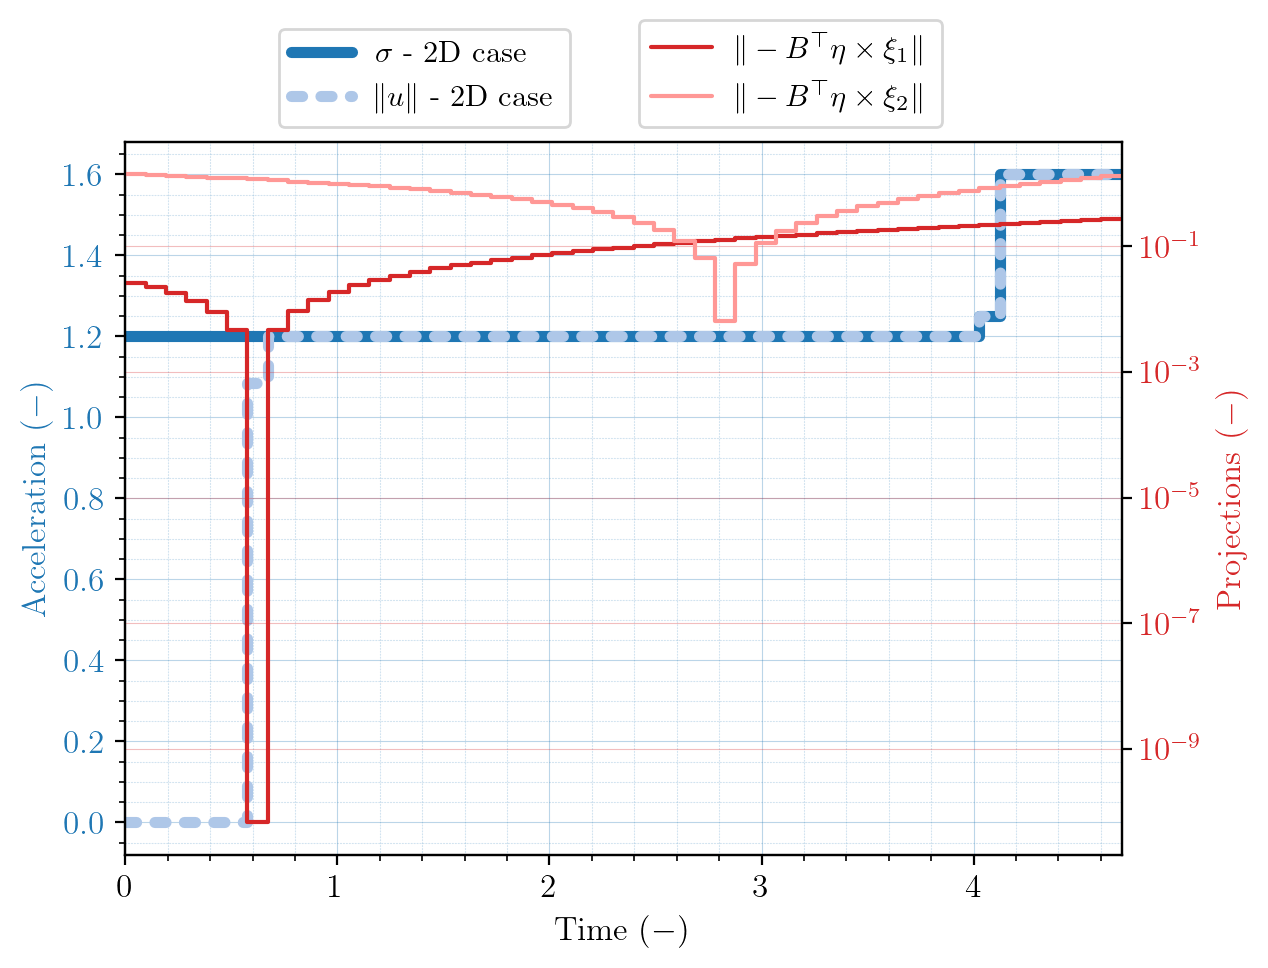

In [10]:

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

dual_list   = [constraints.dual_value for constraints in dynamical_constr]
dual_arr    = np.array( dual_list )

A, B, z  = initDynInt( 0, params )

proj_list   = [ - np.transpose(B[:, :2]) @ arr for arr in dual_list ]
proj_arr    = np.array( proj_list )

cross_list_1    = [ np.cross( proj, params["xi_1"]) for proj in proj_list ]
dot_list_1      = [ np.dot( proj, params["xi_1"]) for proj in proj_list ]
cross_arr_1     = np.array( cross_list_1 )
dot_arr_1       = np.array( dot_list_1 )
cross_list_2    = [ np.cross( proj, params["xi_2"]) for proj in proj_list ]
dot_list_2      = [ np.dot( proj, params["xi_2"]) for proj in proj_list ]
cross_arr_2     = np.array( cross_list_2 )
dot_arr_2       = np.array( dot_list_2 )


fig     = plt.figure(figsize=(6.5,5))
ax      = fig.add_subplot(111)
plt.minorticks_on()

color = colors[0]
ax.plot( time2ZOH(params["tVect"] / t_ref), sig2ZOH(u_fin[2, :]), linewidth=4, label="$\sigma$ - 2D case",  )
ax.plot( time2ZOH(params["tVect"] / t_ref), sig2ZOH(np.linalg.norm(u_fin[0:2, :], axis=0)), linestyle=":",linewidth=4, label="$\|u\|$ - 2D case" )
ax.set_ylabel("Acceleration $(-)$", color=color)
ax.tick_params(axis='y', labelcolor=color)
plt.grid(True, which='major', color=color, linestyle='-', alpha=0.3)
plt.grid(True, which='minor', color=color, linestyle=':', alpha=0.2)
plt.minorticks_on()

ax2             = ax.twinx()
color           = colors[6]
ax2.set_ylabel("Projections $(-)$", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot( time2ZOH(params["tVect"]/ t_ref), cov2ZOH(np.abs(cross_arr_1)), label=r"$\|-B^\top\eta\times\xi_1\|$", color=colors[6] )
ax2.plot( time2ZOH(params["tVect"]/ t_ref), cov2ZOH(np.abs(cross_arr_2)), label=r"$\|-B^\top\eta\times\xi_2\|$", color=colors[7] )
ax.set_xlabel("Time $(-)$")
ax.legend(loc="lower center", bbox_to_anchor=(0.3, 1.0))
ax2.legend(loc="best", bbox_to_anchor=(0.5, 1.0))
plt.grid(True, which='major', color=color, linestyle='-', alpha=0.3)
plt.grid(True, which='minor', color=color, linestyle=':', alpha=0.2)
plt.minorticks_on()
plt.yscale('log') 




In [11]:

def defParameters_3D() -> T.Dict[str, T.Any]:
    
    params = dict()
    params["nx"]        = 6
    params["nu"]        = 4
    params["nNodes"]    = 50
    params["idx_actBC0"] = np.array([True, True, True, True, True, True])
    params["idx_actBCf"] = np.array([True, True, True, True, True, True])

    params = initBcs_3D( params )

    params["Tmax"]      = 20 * 9.81
    params["lowRho"]    = 1.2 * params["Tmax"] 
    params["highRho"]   = 1.6 * params["Tmax"]
    params["tf"]        = 15
    params["kd"]        = 0.05
    params["dt"]        = params["tf"] / params["nNodes"]
    params["tVect"]     = np.linspace(0, params["tf"], params["nNodes"] )
    params["theta"]     = np.radians(55)
    params["gamma"]     = np.cos(params["theta"])
    params["xi_1"]      = np.array([np.cos(params["theta"]), -np.sin(params["theta"]) ])
    params["xi_2"]      = np.array([-np.cos(params["theta"]), -np.sin(params["theta"]) ])
    params["pntVect"]   = np.array([0, 1, 0])
    params["rateLim"]   = 1
    params["mWet"]      = 20

    return params

def initBcs_3D( params: T.Dict[str, T.Any] ):

    params["x_0"] = np.array([   50,  100, 45, -50,  20, 0])
    params["x_f"] = np.array([   0,     0,  0,    0,  0, 0])
    return params


In [12]:

def initDyn_3D( params: T.Dict[str, T.Any]):
    k_d = params["kd"]
    A = np.array([  [0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 1],
                    [0, 0, 0, -k_d, 0, 0],
                    [0, 0, 0, 0, -k_d, 0],
                    [0, 0, 0, 0, 0, -k_d] ])
    B = np.array([  [0, 0, 0, 0],
                    [0, 0, 0, 0],
                    [0, 0, 0, 0],
                    [1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0]  ])
    E = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0],
                  [1, 0, 0], [0, 1, 0], [0, 0, 1]])
    z = lambda t, t_k: np.array([0, -9.81, 0])  

    return A, B, E, z

def initDynInt_3D( t_k, params: T.Dict[str, T.Any] ):
    
    A, B, E, z  = initDyn_3D( params )
    dt          = params["dt"]
    A_k         = sp.linalg.expm(A * dt)
    dxdt        = lambda t, x: sp.linalg.expm( A * (dt - t) ).flatten()
    dzdt        = lambda t, x: (sp.linalg.expm( A * (dt - t) ) @ ( E @ z(t, t_k) ) ).flatten()
    sol_A       = solve_ivp( dxdt, [0, dt], np.zeros( (A_k.shape) ).flatten(), dense_output=True )
    sol_Z       = solve_ivp( dzdt, [0, dt], np.zeros( (A_k.shape[0],) ).flatten(), dense_output=True )
    A_int       = np.reshape( sol_A.sol(dt), A_k.shape )
    B_k         = A_int @ B
    Z_k         = np.reshape( sol_Z.sol(dt), (A_k.shape[0],) )

    A_k      += 1e-5 * np.triu(np.ones((params["nx"], params["nx"]))) - 1e-5 * np.eye(params["nx"])

    return A_k, B_k, Z_k


In [13]:

def initControlMagPathConstraints_3D(   U       : np.ndarray, 
                                        params  : T.Dict[str, T.Any] ):
    constraints = []
    for ii in range( U.shape[1] ):

        constraints += [ cp.norm(U[0:3, ii]) <= U[3, ii]]

        # bounds on acceleration (constant)
        constraints += [ U[3, ii] <=  params["highRho"] / params["mWet"]  ]
        constraints += [ params["lowRho"] /  params["mWet"]  <= U[3, ii] ]

    return constraints

def initControlDirConstraints_3D(   X: np.ndarray,
                                    U : np.ndarray,
                                    params : T.Dict[str, T.Any] ):
    
    pntVect     = params["pntVect"]
    gamma       = params["gamma"]

    constraints = []
    for ii in range( X.shape[1] - 1 ):
        constraints += [ U[0:3, ii] @ pntVect >= gamma * cp.norm(U[0:3, ii]) ]
        
    return constraints

def initDynamicalConstraints_3D(    X: np.ndarray, 
                                    U : np.ndarray, 
                                    params : T.Dict[str, T.Any] ):

    constraints = []
    for ii in range( X.shape[1] - 1 ):
        t_k             = ii * params["dt"]
        A_k, B_k, Z_k   = initDynInt_3D( t_k, params )
        constraints     += [ A_k @ X[:, ii] + B_k @ U[:, ii] + Z_k == X[:, ii + 1] ]   
    
    return constraints


In [14]:

params_2    = defParameters_3D()

# Define problem
X           = cp.Variable( (params_2["nx"], params_2["nNodes"]) )
U           = cp.Variable( (params_2["nu"], params_2["nNodes"]) )
X_last      = np.zeros( X.shape )
U_last      = np.zeros( U.shape )

constraints_3D = []
constraints_3D += initBCsConstraints( X, params_2 )
constraints_3D += initControlMagPathConstraints_3D( U, params_2 )
constraints_3D += initDynamicalConstraints_3D( X, U, params_2 )
constraints_3D += initControlDirConstraints_3D( X, U, params_2 )

# # Objective
objective   = cp.norm1( U[3, :] )
objective_2 = cp.norm1( U[3, :] ) + 10 * cp.sum( cp.norm2(U[0:3, :], axis=0) )


In [15]:

problem_2 = cp.Problem(cp.Minimize( objective ), constraints_3D )
problem_2.solve(solver="QOCO")

u_fin_2       = U.value / a_ref

problem_3 = cp.Problem(cp.Minimize( objective_2 ), constraints_3D )
problem_3.solve(solver="QOCO")

u_fin_3       = U.value / a_ref


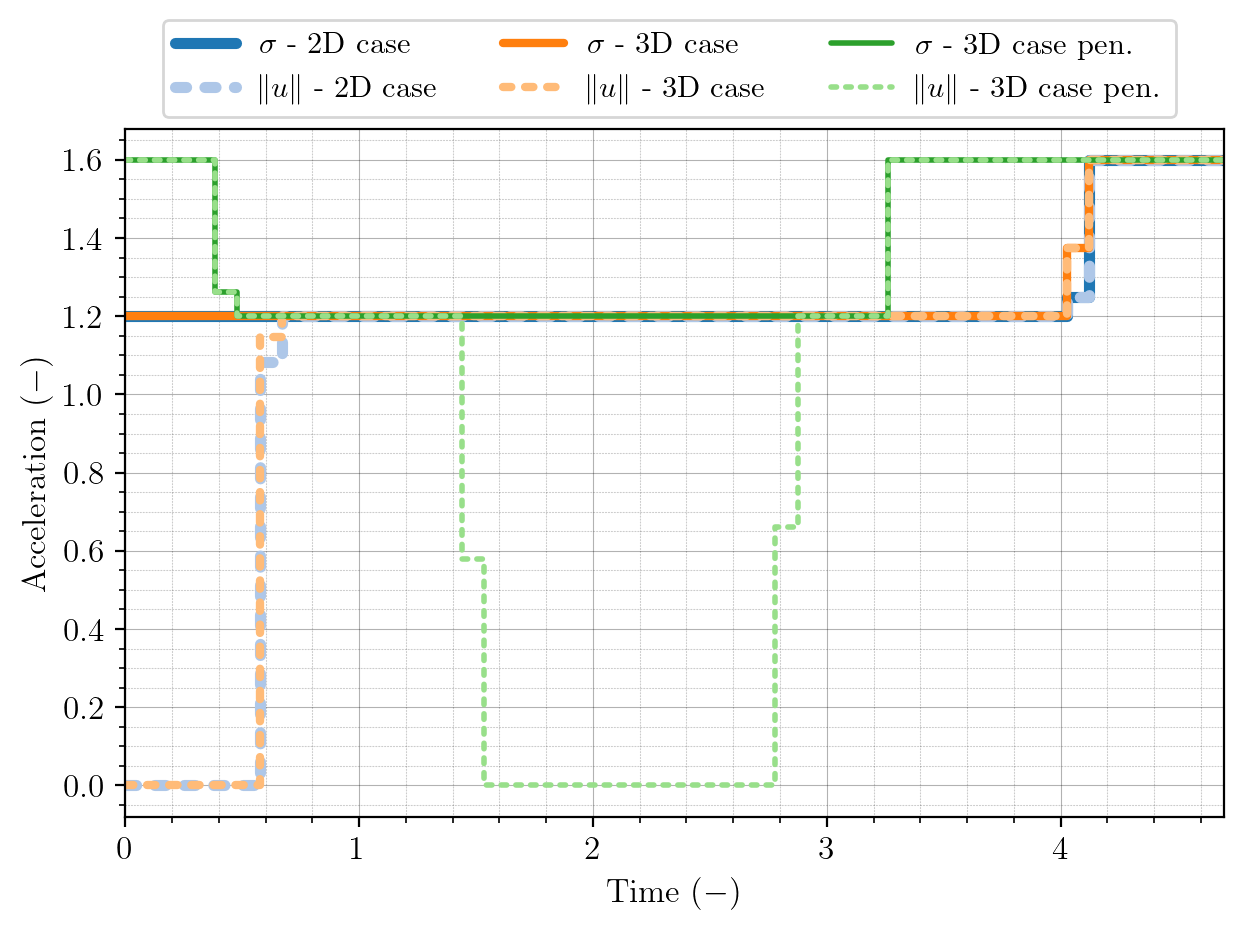

In [16]:

fig     = plt.figure()
ax      = fig.add_subplot(111)

ax.plot( time2ZOH(params["tVect"] / t_ref), sig2ZOH(u_fin[2, :]), linewidth=4, label="$\sigma$ - 2D case" )
ax.plot( time2ZOH(params["tVect"] / t_ref), sig2ZOH(np.linalg.norm(u_fin[0:2, :], axis=0)), linestyle=":",linewidth=4, label="$\|u\|$ - 2D case" )

ax.set_xlabel("Time $(-)$")
ax.set_ylabel("Acceleration $(-)$")
plt.grid(True, which='major', color='k', linestyle='-', alpha=0.3)
plt.grid(True, which='minor', color='k', linestyle=':', alpha=0.2)

ax.plot( time2ZOH(params["tVect"] / t_ref), sig2ZOH(u_fin_2[3, :]), linewidth=3, label="$\sigma$ - 3D case" )
ax.plot( time2ZOH(params["tVect"] / t_ref), sig2ZOH(np.linalg.norm(u_fin_2[0:3, :], axis=0)), linestyle=":",linewidth=3, label="$\|u\|$ - 3D case" )

ax.plot( time2ZOH(params["tVect"] / t_ref), sig2ZOH(u_fin_3[3, :]), linewidth=2, label="$\sigma$ - 3D case pen." )
ax.plot( time2ZOH(params["tVect"] / t_ref), sig2ZOH(np.linalg.norm(u_fin_3[0:3, :], axis=0)), linestyle=":",linewidth=2, label="$\|u\|$ - 3D case pen." )

plt.minorticks_on()
ax.legend(loc="upper left", ncols=3, bbox_to_anchor=(0.02, 1.18))
